Working Memory Decoding
============================================

In [2]:
import mne
from sklearn.decomposition import FastICA, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)

import warnings
from mne.preprocessing import ICA
warnings.filterwarnings('ignore')
from mne import viz
from mne.channels import Layout
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib

Using matplotlib backend: TkAgg


1 - IO
------------------------------------

In [4]:
#Reading fif file
input_fname = '/media/analogicalnexus/2568212B752CDB3B/MEG_Data/R2504_WMD-Filtered-raw.fif'
raw=mne.io.read_raw_fif(input_fname)
raw.load_data()
# raw.plot()

Opening raw data file /media/analogicalnexus/2568212B752CDB3B/MEG_Data/R2504_WMD-Filtered-raw.fif...
    Range : 0 ... 2551999 =      0.000 ...  2551.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 2551999  =      0.000 ...  2551.999 secs...


<Raw  |  R2504_WMD-Filtered-raw.fif, n_channels x n_times : 193 x 2552000 (2552.0 sec), ~3.67 GB, data loaded>

2 - Filtering - Band Pass filter (1-45 Hz)
------------------------------------

In [5]:
#Band pass filter
raw_filtered = raw.filter(l_freq=1, h_freq=45.0, fir_design='firwin')
# raw_40.plot()

Setting up band-pass filter from 1 - 45 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 11.2 Hz
Filter length of 3301 samples (3.301 sec) selected


In [6]:
#Noise Cancellation


3 - ICA
------------------------------------

In [7]:
# #Reference - https://martinos.org/mne/stable/auto_tutorials/plot_artifacts_correction_ica.html
# #ICA parameters
# n_components = 157  # if float, select n_components by explained variance of PCA
# method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
# decim = 3  # we need sufficient statistics, not all time points -> saves time

# # we will also set state of the random number generator - ICA is a
# # non-deterministic algorithm, but we want to have the same decomposition
# # and the same order of components each time this tutorial is run
# random_state = 23

In [8]:
# ica = ICA(n_components=n_components, method=method, random_state=random_state)
# # print(ica)
# reject = dict(mag=5e-12, grad=4000e-13)
# ica.fit(raw_40_ica, picks=picks, decim=decim, reject=reject)
# print(ica)
# ica.plot_components()

In [9]:
# # first, component 0:
# ica.plot_properties(raw_40_ica, picks=range(0,9))

4 - Epoching (Segmenting )
------------------------------------

In [10]:
# # parameter setup for syllable decoding
# event_id_long = dict(nw1=173,nw2=174,nw3=175,w1=163,w2=164,w3=165)
# tmin = 4
# tmax = 12
# baseline = (None,None) 

In [31]:
# parameter setup for rhyme/non-rhyme decoding
events = mne.find_events(raw_filtered)
event_id_long = dict(r=187,nr=188)
tmin = -.2
tmax = .8
baseline = (None,None)

459 events found
Events id: [163 164 165 173 174 175 178 187 188]


In [32]:
#epoching
picks = mne.pick_types(raw_filtered.info, meg=True)
epochs = mne.Epochs(raw_filtered, events, event_id_long, tmin, tmax, proj=False, picks=picks, baseline=baseline)
rhyme = epochs['r'].average()
non_rhyme = epochs['nr'].average()

153 matching events found


5 - Sensor space analysis
------------------------------------

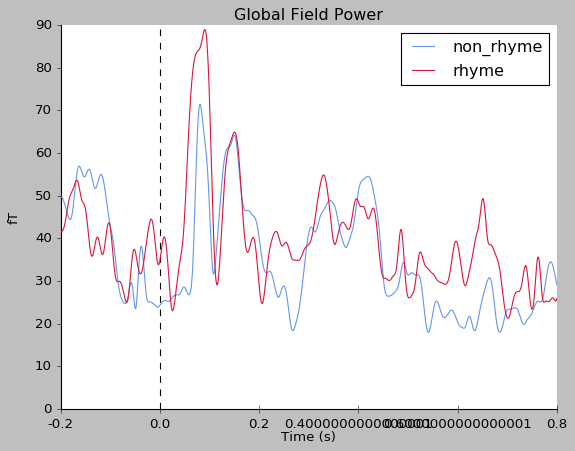

In [33]:
rhyme.plot(spatial_colors=True, gfp=True, ylim=dict(mag=[-300,300]))
non_rhyme.plot(spatial_colors=True, gfp=True, ylim=dict(mag=[-300,300]))
rhyme.plot_topomap(times=[.0, .17, .4],vmin=-300,vmax=300)
non_rhyme.plot_topomap(times=[.0, .17, .4],vmin=-300,vmax=300)
evoked_dict = dict() 
evoked_dict['rhyme'] = rhyme
evoked_dict['non_rhyme'] = non_rhyme
colors=dict(rhyme="Crimson",non_rhyme="CornFlowerBlue") 
mne.viz.plot_compare_evokeds(evoked_dict, colors=colors,
picks=picks, gfp=True)

In [34]:

# la=[0,1,2,3,39,41,42,43,44,52,58,67,71,80,82,83,84,85,108,130,131,132,133,134,135,136,151]
# lp=[4,5,6,7,8,9,34,36,37,38,40,45,46,47,48,49,50,75,76,77,79,87,88,90,127,129,137]
# ra=[20,22,23,24,26,59,60,61,62,63,65,89,92,95,99,100,114,115,116,117,118,145,147,148,152,155]
# rp=[14,15,16,17,18,19,25,27,28,30,53,54,56,57,66,68,69,70,94,96,97,119,121,122,143,144]
# lh=[0,1,2,3,39,41,42,43,44,52,58,67,71,80,82,83,84,85,108,130,131,132,133,134,135,136,151,4,5,6,7,8,9,34,36,37,38,40,45,46,47,48,49,50,75,76,77,79,87,88,90,127,129,137]
# rh=[20,22,23,24,26,59,60,61,62,63,65,89,92,95,99,100,114,115,116,117,118,145,147,148,152,155, 14,15,16,17,18,19,25,27,28,30,53,54,56,57,66,68,69,70,94,96,97,119,121,122,143,144]
# mne.viz.plot_compare_evokeds(evoked_dict, colors=colors,
# picks=lh, gfp=True, ylim=dict(mag=[0,100]))

6 - Frequency domain analysis (PMTM)
------------------------------------

In [ ]:
sfreq = 1000.0
freqs = np.arange(1., 40., .5)
vmin, vmax = -.3e-25, .3e-25  # Define our color limits.
n_cycles = freqs / 2.
time_bandwidth = 8.0  # Same time-smoothing as (1), 7 tapers.
# power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
#                        time_bandwidth=time_bandwidth, return_itc=False,average=False)
power = tfr_array_morlet(epochs.get_data(), sfreq=epochs.info['sfreq'],
                         freqs=freqs, n_cycles=n_cycles)
# Baseline the output
rescale(power, epochs.times, (0., 0.1), mode='mean', copy=False)
# Plot results. Baseline correct based on first 100 ms.
# power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
#            title='Sim: Less time smoothing, more frequency smoothing')

Loading data for 153 events and 1001 original time points ...


In [39]:
print(power.shape)

(153, 157, 10, 1001)


7 - Decoding (MVPA)
------------------------------------

In [ ]:
X = power[:,:,10,:]  # MEG signals: n_epochs, n_channels, n_times
y = epochs.events[:, 2]  # target: rhyme or non-rhyme

clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

# You can retrieve the spatial filters and spatial patterns if you explicitly
# use a LinearModel
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns')

In [ ]:
# define the Temporal Generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc')

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')
plt.show()

# Plot the full matrix
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal Generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)
plt.show()